In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, r2_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, accuracy_score, recall_score
import itertools
import joblib
import json

In [2]:
model_info = {
    'model_name': 'Cost Effective Decision Tree',
    'training_file': 'MLM_Decision_Tree_Misclassification.ipynb',
    'file_name': 'model_dt_step_2_2.pkl',
    'scaler_file': 'model_dt_scaler_step_2_2.pkl',
    'prepared_by': 'Digital Khalid',
    'library': 'Scikit-Learn',
    'classifier': 'Decision Tree Classifier',
    'normalization': 'Standard Scaler (Z-Score)',
    'data_file': 'flows_predicted_elephants.csv',
    'features': ['src_port', 'dst_port', 'protocol', 'first_pkt_size'],
    'target': ['actual_elephant'],
}

In [84]:
# Save model information as json file
with open(f'model_info_{model_info["model_name"]}.json', "w") as outfile:
    json.dump(model_info, outfile)

In [3]:
# Read data file
input_file = model_info['data_file']
input_file
flows = pd.read_csv(input_file)

### Dataset Adjustments

In [4]:
# set elephant flows = 0 where source port, destination port and protocol values are 0, 0, 1 respectively
index = flows[(flows.src_port==0) & (flows.dst_port==0) & (flows.actual_elephant==0)].index
index

Index([    10,     11,     22,     31,     72,     98,    104,    143,    145,
          198,
       ...
       238324, 238339, 238354, 238370, 238373, 238379, 238380, 238389, 238391,
       238408],
      dtype='int64', length=34799)

In [5]:
flows['actual_elephant'].value_counts()

actual_elephant
0    236768
1      1650
Name: count, dtype: int64

In [6]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [7]:
print(f'features (X)\n{X}')

features (X)
        src_port  dst_port  protocol  first_pkt_size
0              0         0         1              70
1          50005      3479        17             183
2          61554       443         6              85
3            443     54447         6            1063
4          47714        80         6              66
...          ...       ...       ...             ...
238413       445     18982         6              62
238414     19770     22022         6              74
238415       443     58289        17            1392
238416     64216       443         6              66
238417      4000      1900        17              83

[238418 rows x 4 columns]


In [8]:
print(f'features (y)\n{y}')

features (y)
        actual_elephant
0                     1
1                     1
2                     0
3                     0
4                     1
...                 ...
238413                0
238414                0
238415                0
238416                0
238417                0

[238418 rows x 1 columns]


In [9]:
# Data Normalization
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_norm = scaler.fit_transform(X)
X_norm

array([[-0.67142868, -0.79523301, -1.36773982, -0.48550793],
       [ 1.73473062, -0.64524522,  1.21543579,  0.05678256],
       [ 2.29044973, -0.77613425, -0.56049744, -0.41352246],
       ...,
       [-0.65011224,  1.71774159,  1.21543579,  5.85881086],
       [ 2.41854084, -0.77613425, -0.56049744, -0.50470405],
       [-0.47895518, -0.71331959,  1.21543579, -0.42312052]])

In [123]:
joblib.dump(scaler, model_info['scaler_file'])

['model_dt_scaler_step_2_2.pkl']

In [124]:
flows['actual_elephant'].value_counts()/ flows.shape[0] * 100

actual_elephant
0    99.307938
1     0.692062
Name: count, dtype: float64

### Cost Effective Decision Tree (Finding and best class weights and hyperparameters using Grid Search CV)

In [57]:
# define model
model = DecisionTreeClassifier()

In [62]:
# define grid
# balance = [{0:1,1:1000}, {0:1,1:500}, {0:1,1:250}]
class_weight = [{0:1,1:1000}, {0:1,1:1500}]
max_depth = [10, 15]
min_samples_split = [20, 25]
criterion = ['gini', 'entropy']
splitter = ['best']
# splitter = ['best', 'random']

param_grid = {
    'class_weight': class_weight,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'criterion': criterion,
    'splitter': splitter,
}

In [63]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define the scoring metric you want to use
scoring_metric = make_scorer(f1_score)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-3, cv=cv, scoring='roc_auc', verbose=3)

In [64]:
# execute the grid search
grid_result = grid.fit(X_norm, y)

Fitting 30 folds for each of 16 candidates, totalling 480 fits
[CV 5/30] END class_weight={0: 1, 1: 1000}, criterion=gini, max_depth=10, min_samples_split=20, splitter=best;, score=0.890 total time=   0.7s
[CV 8/30] END class_weight={0: 1, 1: 1000}, criterion=gini, max_depth=10, min_samples_split=20, splitter=best;, score=0.916 total time=   0.9s
[CV 14/30] END class_weight={0: 1, 1: 1000}, criterion=gini, max_depth=10, min_samples_split=20, splitter=best;, score=0.922 total time=   0.8s
[CV 20/30] END class_weight={0: 1, 1: 1000}, criterion=gini, max_depth=10, min_samples_split=20, splitter=best;, score=0.918 total time=   0.8s
[CV 25/30] END class_weight={0: 1, 1: 1000}, criterion=gini, max_depth=10, min_samples_split=20, splitter=best;, score=0.899 total time=   0.9s
[CV 1/30] END class_weight={0: 1, 1: 1000}, criterion=gini, max_depth=10, min_samples_split=25, splitter=best;, score=0.907 total time=   0.8s
[CV 7/30] END class_weight={0: 1, 1: 1000}, criterion=gini, max_depth=10, mi

In [65]:
# report the best configuration
print(f'\nBest Score: {grid_result.best_score_:.3f} achieved using following parameters: \n{grid_result.best_params_}\n')

# report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


Best Score: 0.919 achieved using following parameters: 
{'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 20, 'splitter': 'best'}



### Cost Effective Decision Tree (Using best hyperparameters)

In [66]:
# Extracted best hyperparameter values using grid search
best_param_grid = {
    'class_weight': {0:1, 1:2000},
    'max_depth': 10,
    'min_samples_split': 20,
    'criterion': 'gini',
    'splitter': 'best',
}

In [67]:
# define model
model = DecisionTreeClassifier(**best_param_grid)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [69]:
X_test

array([[-0.66757921,  1.5541303 , -0.56049744, -0.50470405],
       [-0.65011224,  1.69118439, -0.56049744, -0.28394863],
       [-0.67142868, -0.79523301, -1.36773982, -0.35113506],
       ...,
       [-0.64905364,  0.65696271, -0.56049744, -0.4663118 ],
       [ 0.23030965, -0.79294806,  1.21543579, -0.36553215],
       [ 2.27678411, -0.77613425, -0.56049744, -0.38952731]])

In [70]:
y_test.value_counts()

actual_elephant
0                  59192
1                    413
Name: count, dtype: int64

In [71]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 2000}, max_depth=10,
                       min_samples_split=20)

In [72]:
y_pred = model.predict(X_test)

In [73]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'False Positive Rate: {fpr[1]}\nTrue Positive Rate: {tpr[1]}\nROC_AUC: {roc_auc}')

Precision: 0.5119810187651906
Recall: 0.8371484579913455
F1 Score: 0.4498290033108217
Accuracy: 0.7434107876855969
False Positive Rate: 0.2579064738478173
True Positive Rate: 0.9322033898305084
ROC_AUC: 0.8371484579913456


In [12]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
scores = cross_val_score(model, X_norm, y, scoring='roc_auc', cv=cv, n_jobs=-2)
np.mean(scores)

### Save Model File

In [74]:
joblib.dump(model, model_info['file_name'])

['model_dt_step_2_2.pkl']

### Load Model File (Further Evaluation)

In [10]:
model = joblib.load(model_info['file_name'])

In [11]:
scaler = joblib.load(model_info['scaler_file'])

In [12]:
model.feature_importances_

array([0.44985867, 0.36366951, 0.0147356 , 0.17173622])

In [78]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [79]:
X_norm = scaler.transform(X)

In [80]:
predictions = model.predict(X_norm)

In [81]:
predictions

array([1, 1, 1, ..., 1, 0, 0])

In [82]:
predictions = pd.Series(predictions, index=X.index)
predictions

0         1
1         1
2         1
3         0
4         1
         ..
238413    1
238414    0
238415    1
238416    0
238417    0
Length: 238418, dtype: int64

In [83]:
flows['packet_count']

0          8463
1          4697
2             2
3            76
4         67041
          ...  
238413        1
238414        1
238415        2
238416        1
238417        1
Name: packet_count, Length: 238418, dtype: int64

In [84]:
pred_flows = pd.concat([X, y, predictions], axis=1)
pred_flows

,src_port,dst_port,protocol,first_pkt_size,actual_elephant,0
0,0,0,1,70,1,1
1,50005,3479,17,183,1,1
2,61554,443,6,85,0,1
3,443,54447,6,1063,0,0
4,47714,80,6,66,1,1
...,...,...,...,...,...,...
238413,445,18982,6,62,0,1
238414,19770,22022,6,74,0,0
238415,443,58289,17,1392,0,1
238416,64216,443,6,66,0,0


In [85]:
pred_flows.rename(columns={0: 'predicted_elephant'}, inplace=True)

In [86]:
pred_flows

,src_port,dst_port,protocol,first_pkt_size,actual_elephant,predicted_elephant
0,0,0,1,70,1,1
1,50005,3479,17,183,1,1
2,61554,443,6,85,0,1
3,443,54447,6,1063,0,0
4,47714,80,6,66,1,1
...,...,...,...,...,...,...
238413,445,18982,6,62,0,1
238414,19770,22022,6,74,0,0
238415,443,58289,17,1392,0,1
238416,64216,443,6,66,0,0


In [87]:
pred_flows.query('actual_elephant != predicted_elephant')

,src_port,dst_port,protocol,first_pkt_size,actual_elephant,predicted_elephant
2,61554,443,6,85,0,1
10,0,0,1,70,0,1
11,0,0,1,70,0,1
15,60320,443,6,85,0,1
17,443,55879,6,1514,0,1
...,...,...,...,...,...,...
238397,443,51946,17,1292,0,1
238398,443,63096,17,1292,0,1
238399,443,62087,17,1292,0,1
238413,445,18982,6,62,0,1


In [88]:
pred_flows.query('actual_elephant==0 & predicted_elephant==1')

,src_port,dst_port,protocol,first_pkt_size,actual_elephant,predicted_elephant
2,61554,443,6,85,0,1
10,0,0,1,70,0,1
11,0,0,1,70,0,1
15,60320,443,6,85,0,1
17,443,55879,6,1514,0,1
...,...,...,...,...,...,...
238397,443,51946,17,1292,0,1
238398,443,63096,17,1292,0,1
238399,443,62087,17,1292,0,1
238413,445,18982,6,62,0,1


In [89]:
# pd.set_option('display.max_rows', None)
pred_flows[pred_flows['predicted_elephant'] == 0].value_counts()

src_port  dst_port  protocol  first_pkt_size  actual_elephant  predicted_elephant
0         0         1         98              0                0                     19684
5100      5060      17        457             0                0                      8599
                              456             0                0                      7308
500       500       17        246             0                0                      5789
5100      5060      17        458             0                0                      5342
                                                                                     ...  
443       13392     6         58              0                0                         1
          13363     6         58              0                0                         1
          13301     6         58              0                0                         1
          13276     6         58              0                0                         1
65534   

In [113]:
pred_flows.query('src_port==0 & dst_port==0 & actual_elephant==0 & predicted_elephant==0').value_counts()

src_port  dst_port  protocol  first_pkt_size  actual_elephant  predicted_elephant
0         0         1         98              0                0                     19684
                              94              0                0                      2210
                              74              0                0                      1660
                              82              0                0                       703
                              78              0                0                       538
                                                                                     ...  
                              300             0                0                         1
                              343             0                0                         1
                              344             0                0                         1
                              370             0                0                         1
        

In [100]:
pred_flows.query('protocol==17 & actual_elephant==0 & predicted_elephant==1').value_counts()

src_port  dst_port  protocol  first_pkt_size  actual_elephant  predicted_elephant
51799     5060      17        370             0                1                     104
30321     123       17        234             0                1                      89
54588     11900     17        139             0                1                      75
53614     4498      17        1290            0                1                      70
54438     5060      17        420             0                1                      65
                                                                                    ... 
443       64267     17        246             0                1                       1
          64251     17        1292            0                1                       1
          64248     17        1292            0                1                       1
          64242     17        1292            0                1                       1
64340     63853     17      

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [15]:
y_pred = model.predict(X_test)

In [16]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'False Positive Rate: {fpr[1]}\nTrue Positive Rate: {tpr[1]}\nROC_AUC: {roc_auc}')

Precision: 0.5119810187651906
Recall: 0.8371484579913455
F1 Score: 0.4498290033108217
Accuracy: 0.7434107876855969
False Positive Rate: 0.2579064738478173
True Positive Rate: 0.9322033898305084
ROC_AUC: 0.8371484579913456


0

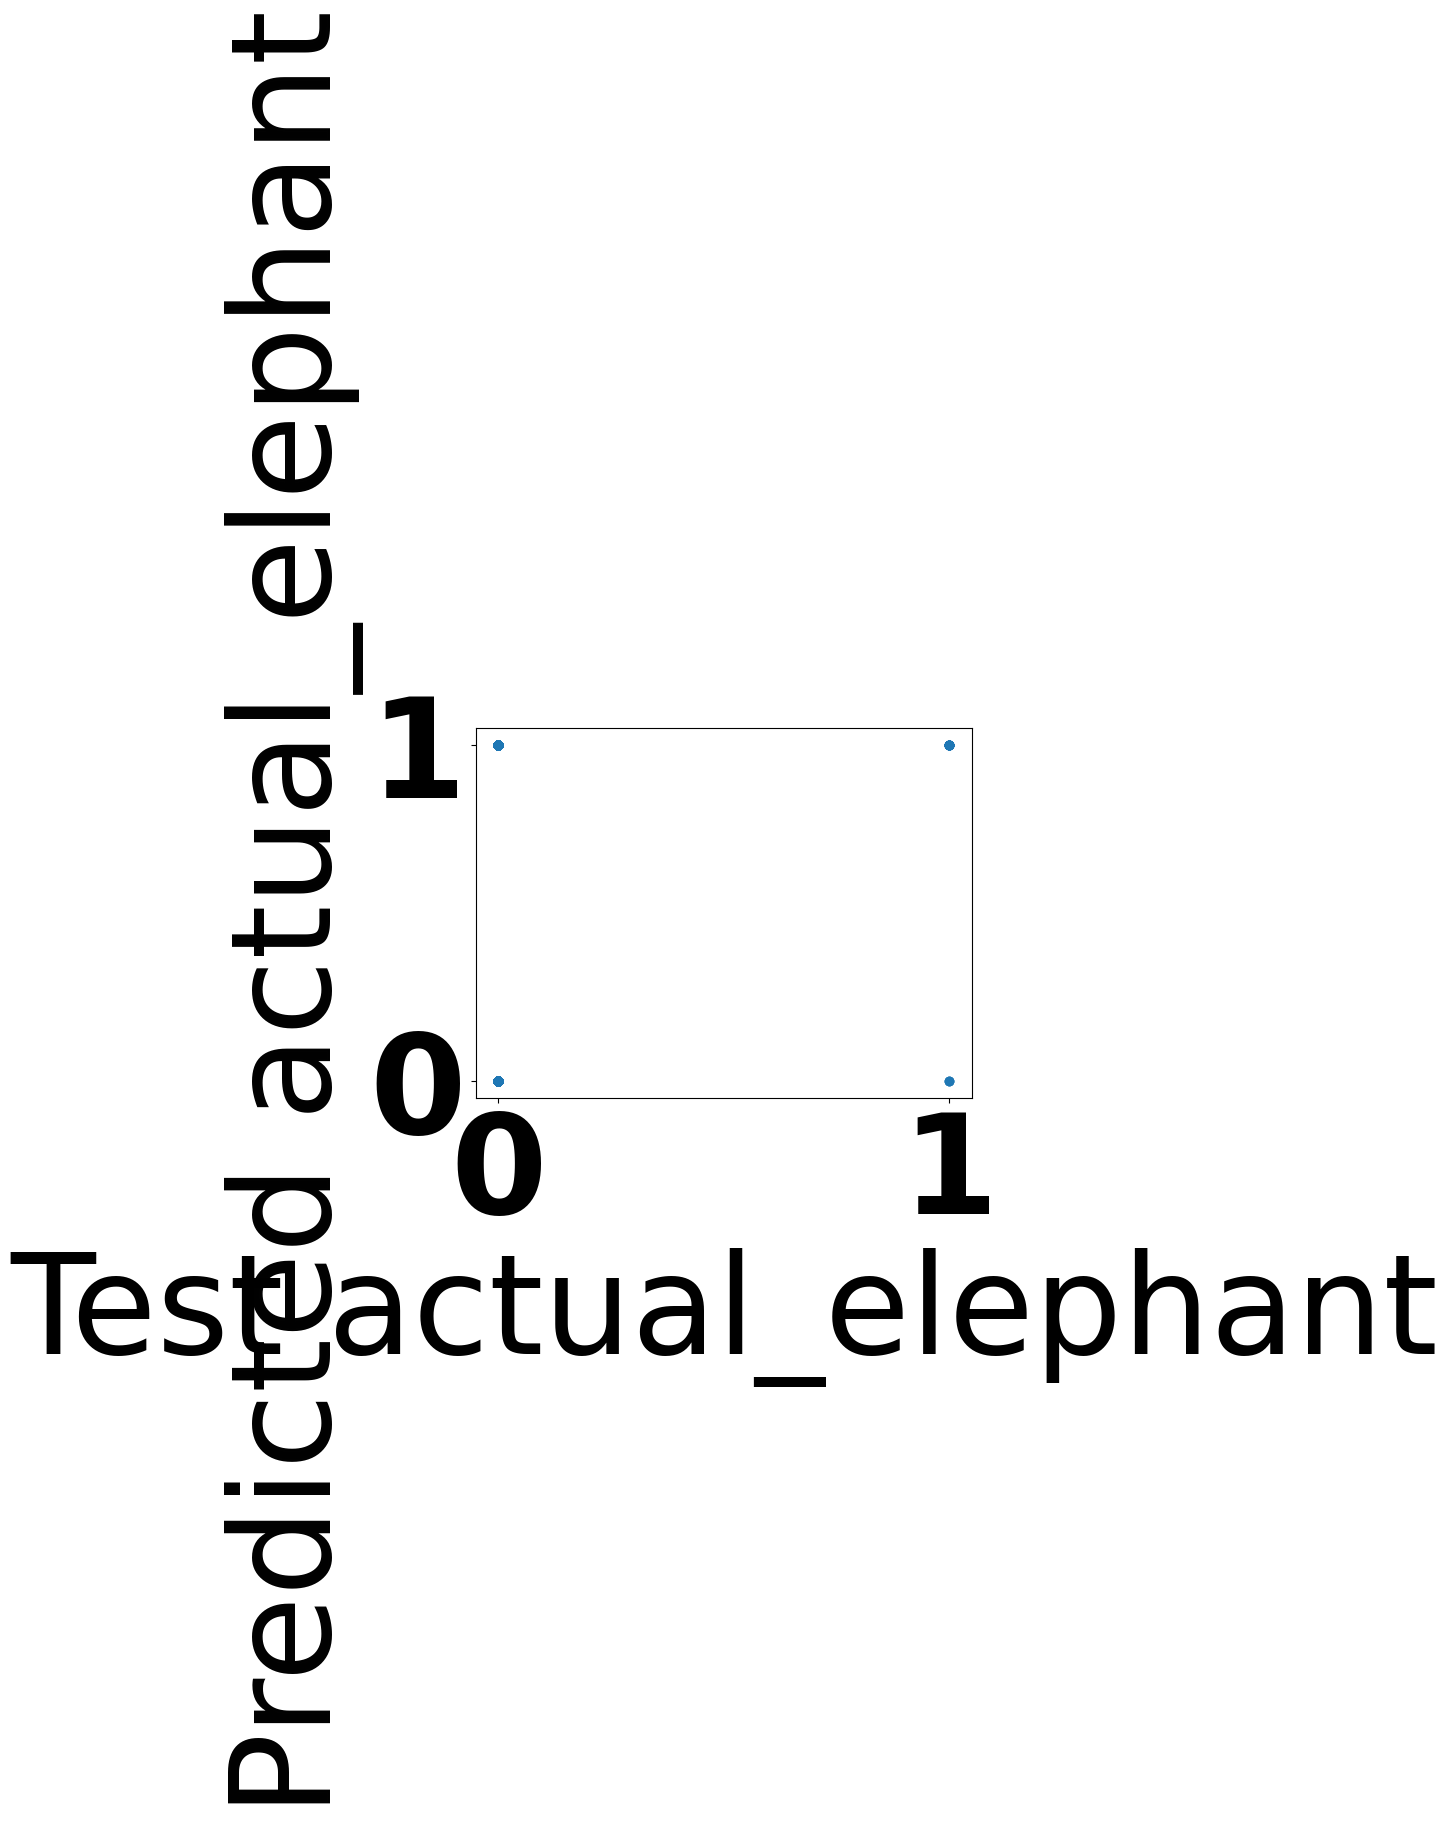

In [58]:
fig, ax = plt.subplots()
ax.set_xlabel('Test ' + target[0])
ax.set_ylabel('Predicted ' + target[0])
ax.scatter(y_test, y_pred)

(array([5.9192e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

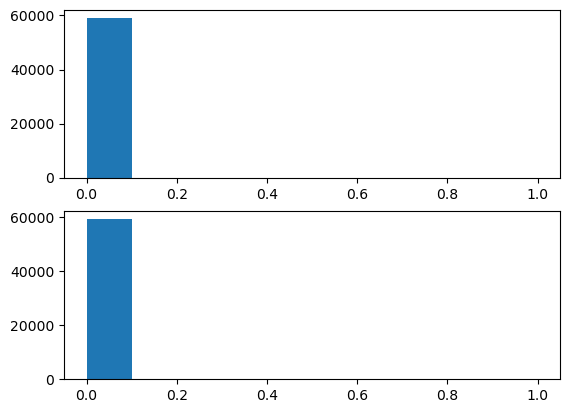

In [22]:
fig, ax = plt.subplots(2)
ax[0].hist(y_test)
ax[1].hist(y_pred)

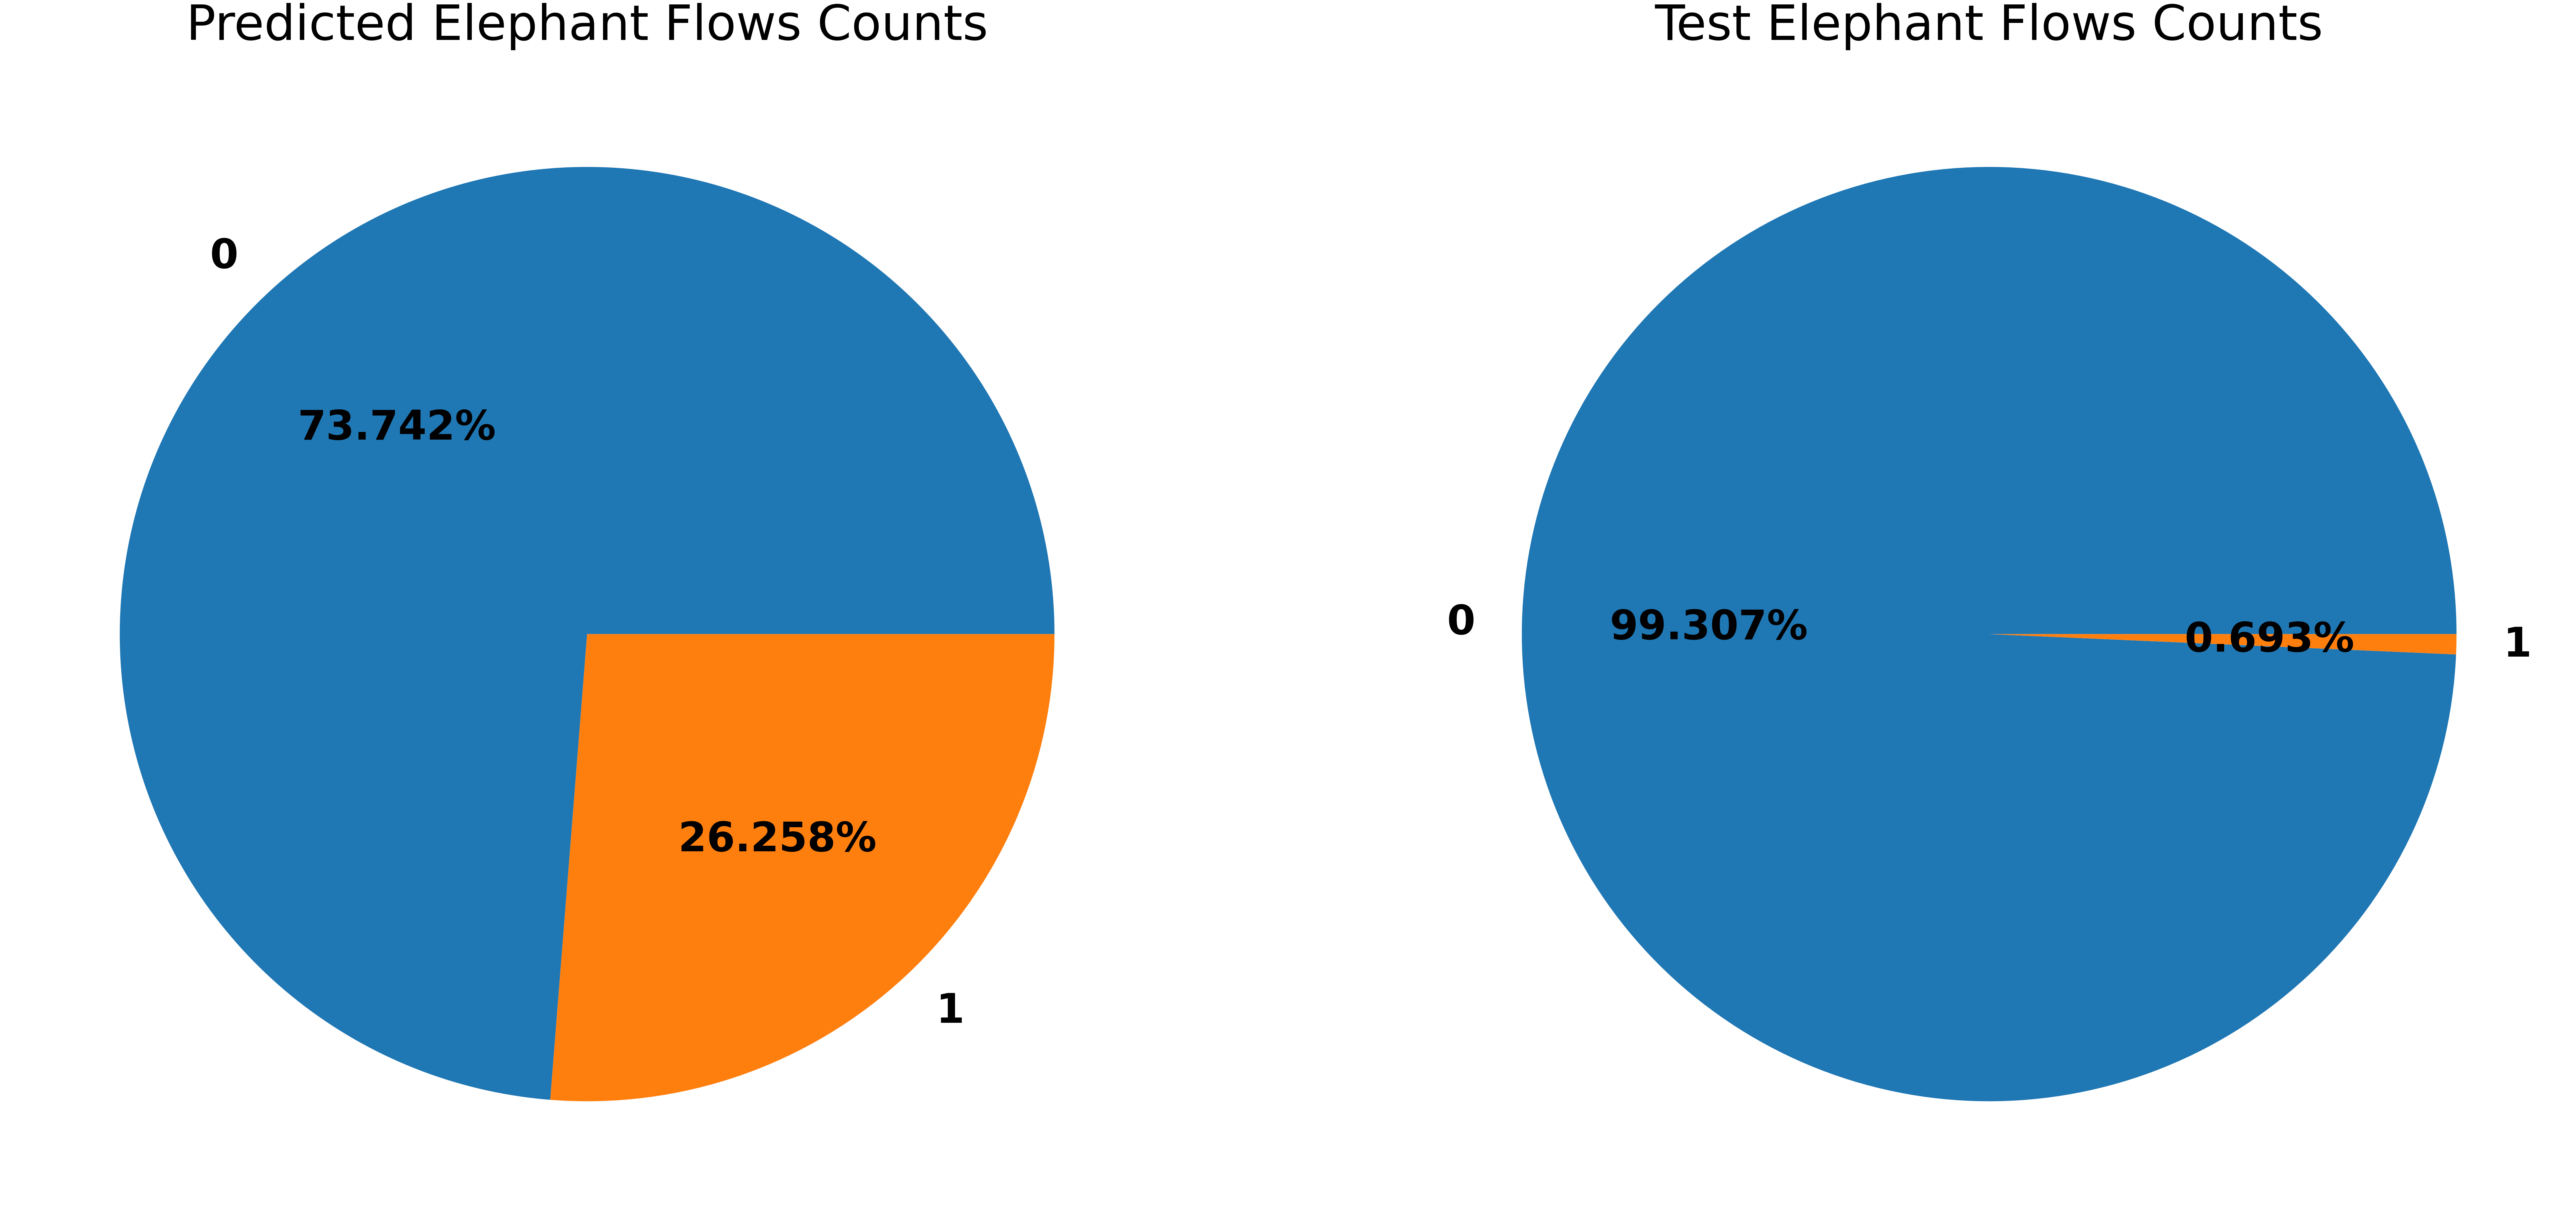

In [101]:
predictions = pd.DataFrame(y_pred)
testset = pd.DataFrame(y_test)

# get the set of distinct classes
labels_pred = predictions[0].unique()
labels_test = testset.actual_elephant.unique()

# get the count of each class
sizes_pred = predictions[0].value_counts().values
sizes_test = testset.actual_elephant.value_counts().values

font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 100}

matplotlib.rc('font', **font)

# plot the class value counts
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(100, 100))
plt.subplots_adjust(bottom=0.1, right=1, top=0.5)

ax[0].pie(sizes_pred, labels=labels_pred, autopct='%1.3f%%')
ax[0].set_title('Predicted Elephant Flows Counts')

ax[1].pie(sizes_test, labels=labels_test, autopct='%1.3f%%')
ax[1].set_title('Test Elephant Flows Counts')

plt.show()

In [102]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[  385    28]
 [15266 43926]]


Confusion matrix, without normalization
[[  385    28]
 [15266 43926]]


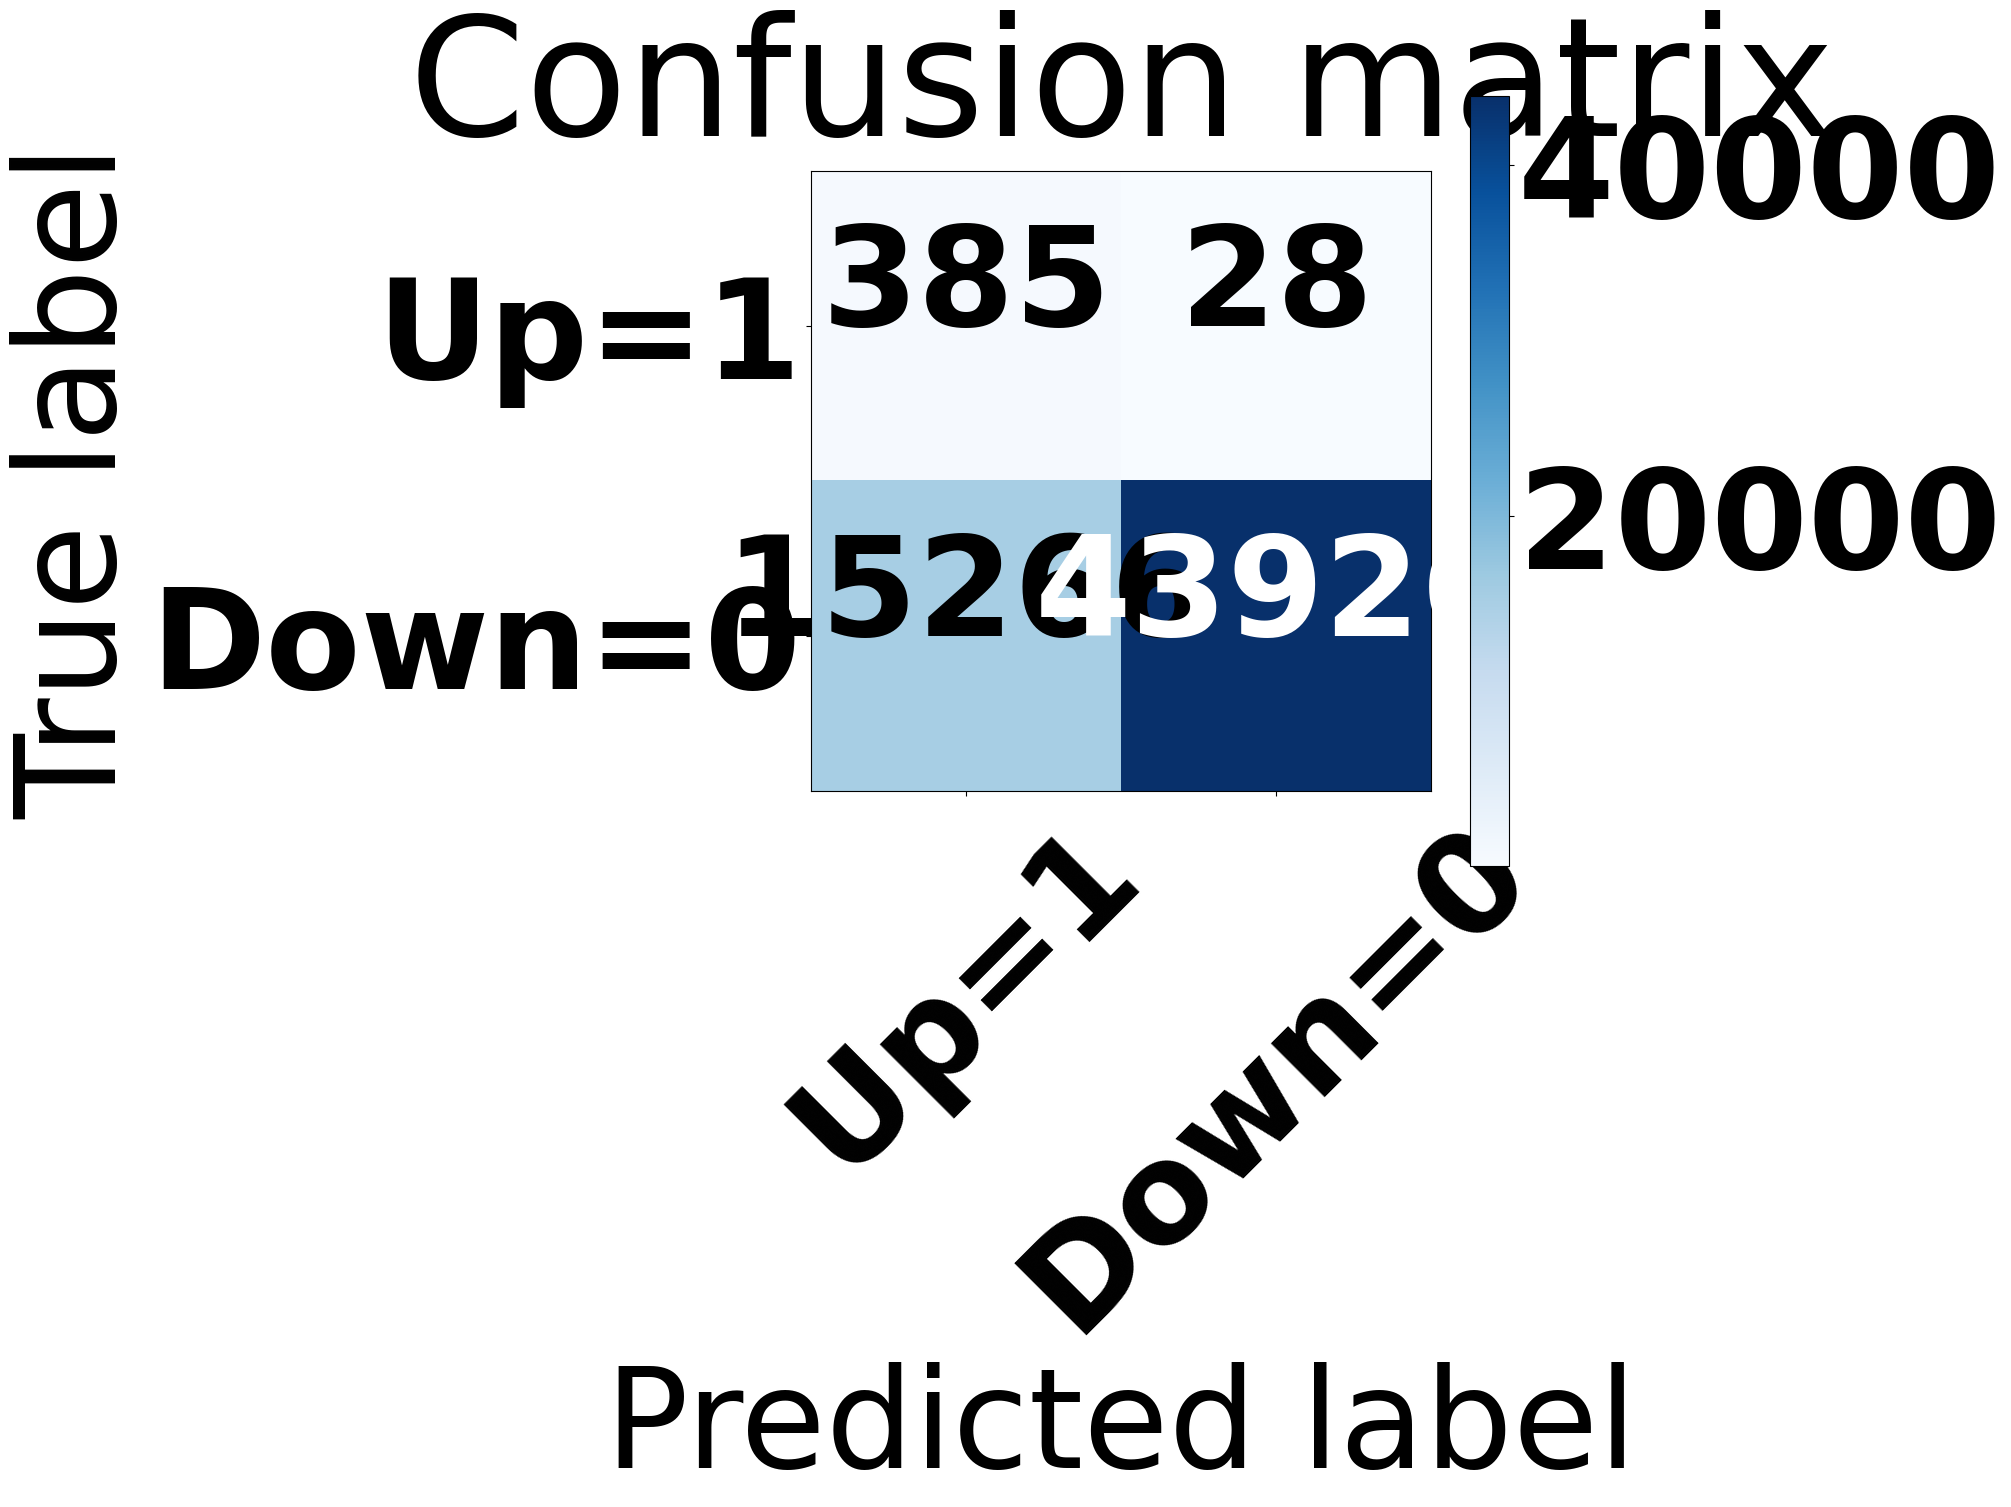

In [103]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['Up=1','Down=0'], normalize=False, title='Confusion matrix')


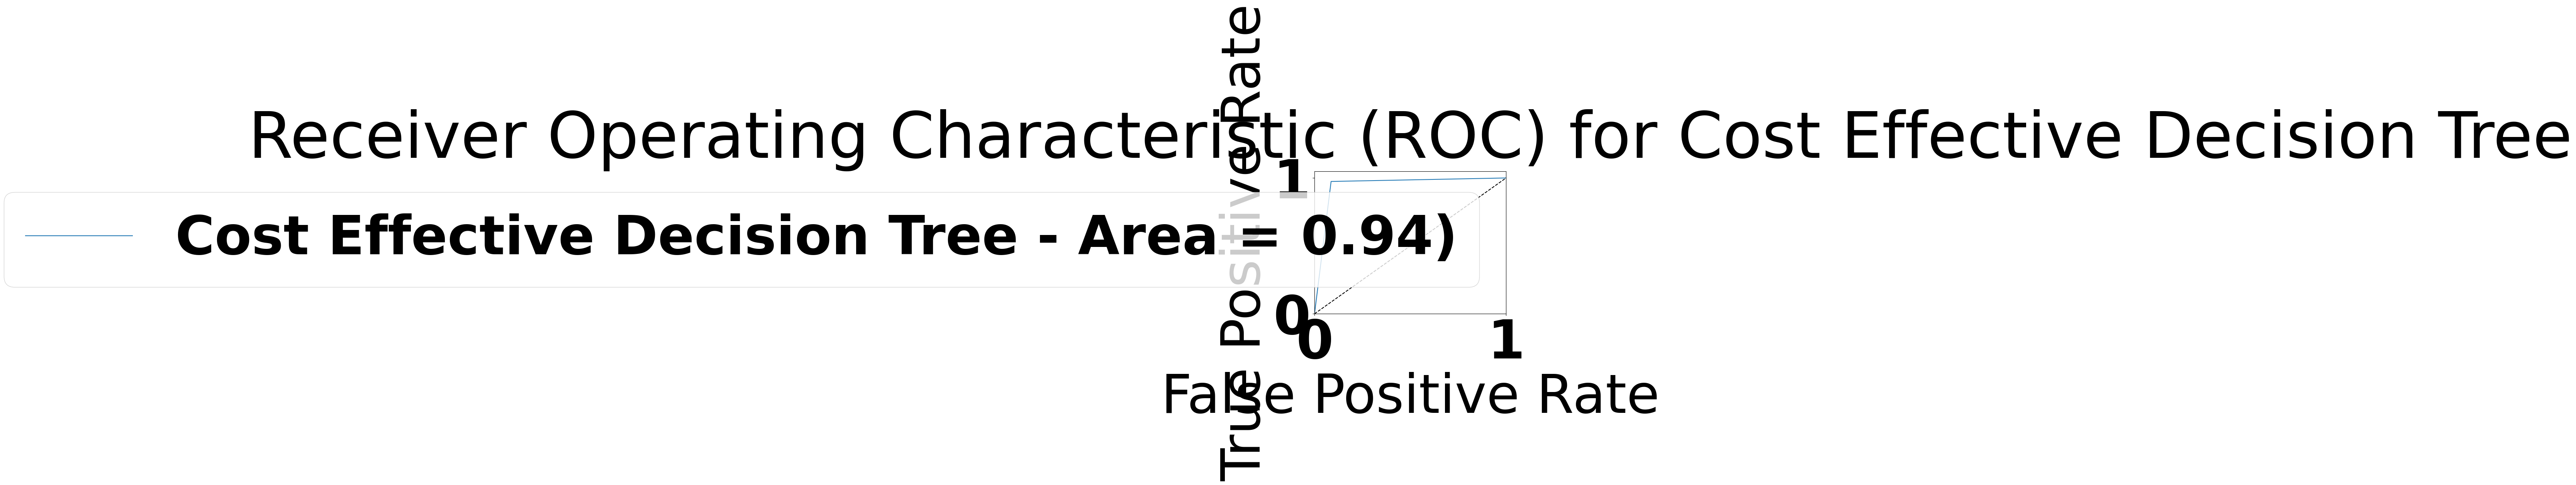

In [99]:
# Plot ROC curve
plt.plot(fpr, tpr, label=f"Cost Effective Decision Tree - Area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) for Cost Effective Decision Tree')
plt.legend(loc="lower right")

# Save the ROC curve plot as an image
# plt.savefig(f"ROC_Curve_CEDT.png")

# Show the ROC curve plot
plt.show()

In [24]:
features = {
        'protocol': 12,
        'src_port': 13,
        'dst_port': 14,
        'first_pkt_size': 15,
}

In [30]:
[value for value in features.values()]

[12, 13, 14, 15]

In [31]:
features.values()

dict_values([12, 13, 14, 15])